In [23]:
import os
import os.path as osp

import datetime as DT

import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd

import ipywidgets as widgets
from ipywidgets import interactive, HBox
from ipyfilechooser import FileChooser
from IPython.display import display

import manipylator
import manipylator.utils as utils 
import manipylator.gui as gui
import manipylator.analysis as man
from manipylator.utils import printmd 
from manipylator.controller import Controller, get_stage_prop

cwd = os.getcwd()

df_canti = pd.read_csv('data/cantilever_database.csv')

import importlib
manipylator = importlib.reload(manipylator)
man = importlib.reload(manipylator.analysis)
#utils = importlib.reload(manipylator.utils)
#gui = importlib.reload(manipylator.gui)

%matplotlib widget


                        _             _       _             
  _ __ ___   __ _ _ __ (_)_ __  _   _| | __ _| |_ ___  _ __ 
 | '_ ` _ \ / _` | '_ \| | '_ \| | | | |/ _` | __/ _ \| '__|
 | | | | | | (_| | | | | | |_) | |_| | | (_| | || (_) | |   
 |_| |_| |_|\__,_|_| |_|_| .__/ \__, |_|\__,_|\__\___/|_|   
                         |_|    |___/                       
 
 A Python-driven manipulator controller 

 Developed and maintained by Arthur Michaut: arthur.michaut@gmail.com 




## Analysis

In [2]:
printmd("**Choose the root directory**")
printmd("This is the directory that my change (desktop, etc.)")
fc_root = FileChooser('/Users/amichaut/Desktop')
fc_root.use_dir_icons = True
display(fc_root)

**Choose the root directory**

This is the directory that my change (desktop, etc.)

FileChooser(path='/Users/amichaut/Desktop', filename='', title='', show_hidden=False, select_desc='Select', ch…

In [3]:
root_dir = fc_root.selected_path

printmd("**Choose the data directory**")
fc_data = FileChooser(fc_root.selected_path)
fc_data.use_dir_icons = True
display(fc_data)

**Choose the data directory**

FileChooser(path='/Users/amichaut/Desktop', filename='', title='', show_hidden=False, select_desc='Select', ch…

In [89]:
relative_path = fc_data.selected_path[len(root_dir)+1:]  # part of the path after root directory

printmd("**(Optionnal) choose czi file to get metadata**")
fc_czi = FileChooser(osp.join(root_dir,relative_path))
fc_czi.use_dir_icons = True
display(fc_czi)

**(Optionnal) choose czi file to get metadata**

FileChooser(path='/Users/amichaut/Desktop/20240816_gel/11_gel3_p2', filename='', title='', show_hidden=False, …

In [91]:
# display czi timestamp
if fc_czi.selected is not None: 
    df_czi = man.get_stack_acquisition_time(fc_czi.selected)
    printmd('czi file metadata:')
    print(df_czi.head(5))

# mandatory parameters
lengthscale = 2.2097  # in um/px
dt = 1  # in sec
canti_id = 16  # id used in cantilever database
canti_length = float(df_canti[df_canti['ID']==str(canti_id)]['length'].values[0])  # in mm
contact_area = 6089  # in um^2, only for Chirp
fn_image_tip = 'tip.tif'
fn_tip = 'bead_tracking/tip_pos.csv'


# exp info for chirp
exp_chirp = {'exp_dir': relative_path,
            'fn_image_tip': fn_image_tip,
            'fn_tip': fn_tip,
            'frame_interval': dt,
            'canti_id' : canti_id,
            'canti_length' : canti_length,
            'lengthscale' : lengthscale,
            'fn_stage': '06_chirp.csv',
            'date': "2022:12:09",
            't0_tip': "14:52:10.2653", #absolute time of first image
            'contact_area': contact_area, #in um^2
            'tip_radius' : None, #in px
            'w0' : 0.02, # low angular frequency
            'w1' : 0.2, # high angular frequency
          } 

# exp info for PID
exp_PID = { 'exp_dir': relative_path,
            'fn_image_tip': fn_image_tip,
            'fn_tip': fn_tip,
            'frame_interval': dt,
            'canti_id' : canti_id, 
            'canti_length' : canti_length,
            'lengthscale' : lengthscale, #in um
            'PID_fn_list' : ['08_PID_in-oil_xyz-locked.csv'],
            'sign' : -1,  # sign of the movement -1 if -> left, +1 if -> right
            'relax_time': 300, # starting time of relaxation phase in sec
            'set_deflection': 30,  # in um
            't0_tip': None,  # relative time of first movement (to be used in case of retracked data), otherwise None
            'contact_area': None, #in um^2
            'tip_radius' : None, #in px
          }

# exp info for sweep
exp_sweep = {'exp_dir': relative_path,
            'fn_image_tip': fn_image_tip,
            'fn_tip': fn_tip,
            'frame_interval': dt,
            'canti_id' : canti_id, 
            'canti_length' : canti_length,
            'lengthscale' : lengthscale,
            'fn_stage': ['11_gel3_sweep_position2.csv'],  #can be a list if several files
            'date': "2024:08:16",
            't0_tip': "15:53:49.0759", #absolute time of first image
            'contact_area': None, #in um^2
            'tip_radius' : None, #in px
            'time_adjust': None,  # timestamp correction {'timestamp': new_timestamp, 'frame': first frame to correct}
            'offset_definition': None,  # offset definition from another exp (in um)
            } 

info_fn = osp.join(fc_data.selected_path,'info.csv')

# chirp button
description = "Write chirp info" if not osp.exists(info_fn) else "Refresh chirp info"
chirp_wid = widgets.Button(value=True, description=description)

def make_chirp_info(obj):
    utils.write_dict(exp_chirp,info_fn)
    
chirp_wid.on_click(make_chirp_info)

# PID button
description = "Write PID info" if not osp.exists(info_fn) else "Refresh PID info"
PID_wid = widgets.Button(value=True, description=description)

def make_PID_info(obj):
    utils.write_dict(exp_PID,info_fn)
    
PID_wid.on_click(make_PID_info)

# sweep button
description = "Write sweep info" if not osp.exists(info_fn) else "Refresh sweep info"
sweep_wid = widgets.Button(value=True, description=description)

def make_sweep_info(obj):
    utils.write_dict(exp_sweep,info_fn)
    
sweep_wid.on_click(make_sweep_info)

printmd("Saving to: {}".format(info_fn))
display(HBox([chirp_wid,PID_wid,sweep_wid]))

czi file metadata:

   T  C        date           time        timestamp
0  0  0  2024-08-16  13:53:49.0759  1723809229.0759
1  0  1  2024-08-16  13:53:49.0759  1723809229.0759
2  1  0  2024-08-16  13:53:50.0795  1723809230.0795
3  1  1  2024-08-16  13:53:50.0795  1723809230.0795
4  2  0  2024-08-16  13:53:51.0796  1723809231.0796


Saving to: /Users/amichaut/Desktop/20240816_gel/11_gel3_p2/info.csv

In [92]:
# load info
info_fn = osp.join(fc_data.selected_path,'info.csv')
if osp.exists(info_fn):
    exp = utils.load_dict(info_fn)
    if type(exp['exp_dir']) is int: 
        exp['exp_dir'] = str(exp['exp_dir'])
    print('info loaded from {}'.format(osp.join(root_dir,exp['exp_dir'])))
    print(exp)
else: 
    print('ERROR: {} does not exist'.format(info_fn))
    
# adding root_dir to exp info
exp['root_dir'] = root_dir

info loaded from /Users/amichaut/Desktop/20240816_gel/11_gel3_p2
{'exp_dir': '20240816_gel/11_gel3_p2', 'fn_image_tip': 'tip.tif', 'fn_tip': 'bead_tracking/tip_pos.csv', 'frame_interval': 1, 'canti_id': 16, 'canti_length': 38.75, 'lengthscale': 2.2097, 'fn_stage': ['11_gel3_sweep_position2.csv'], 'date': '2024:08:16', 't0_tip': '15:53:49.0759', 'contact_area': None, 'tip_radius': None, 'time_adjust': None, 'offset_definition': None}


## Tracking

### Pattern recognition, define ROI

In [93]:
stack_fn = osp.join(root_dir,exp['exp_dir'],exp['fn_image_tip'])
stack = imread(stack_fn)
image = stack[0]
h,w = image.shape

interactive_plot_param = interactive(utils.select_ROI,
                                     x_range=widgets.IntRangeSlider(min=0,max=w,value=[0,w],continuous_update=False),
                                     y_range=widgets.IntRangeSlider(min=0,max=h,value=[0,h],continuous_update=False),
                                     intensity_range=widgets.IntRangeSlider(min=0,max=255,value=[0,255],continuous_update=False),
                                     frame=widgets.IntSlider(min=0,max=len(stack),value=0,continuous_update=False),
                                     fn=stack_fn,
                                     continuous_update=False
                                    )
interactive_plot_param

interactive(children=(Text(value='/Users/amichaut/Desktop/20240816_gel/11_gel3_p2/tip.tif', description='fn'),…

In [94]:
x_range = interactive_plot_param.children[1].value
y_range = interactive_plot_param.children[2].value
frame = interactive_plot_param.children[3].value
ROI = stack[frame][y_range[0]:y_range[1], x_range[0]:x_range[1]]
fig, ax = plt.subplots()
ax.imshow(ROI, cmap=plt.cm.gray)
plt.show(fig)

In [95]:
# get optimized parameters
parallel = True

stack_fn = osp.join(root_dir,exp['exp_dir'],exp['fn_image_tip'])
outdir = osp.join(root_dir,exp['exp_dir'],'bead_tracking')
if not osp.exists(outdir):
    os.mkdir(outdir)


# run tracking
if parallel:
    arg_dict = {'method':"pattern",
                "pattern":ROI,
                'outdir':outdir,
                'plot_seg':True,
                'debug':False,
                'save_image':True,
                'dpi':300,
                }
    df_tip = man.parallel_track_bead(stack_fn,arg_dict)
else: 
    df_tip = man.track_bead(stack_fn,method="pattern",seg_param={"pattern":ROI},outdir=outdir,save_image=True)

df_tip.plot(x='frame',y='cx')

# fig,ax=plt.subplots()
# df_tip.plot(x='cx',y='cy',ax=ax,legend=False)
# ymin,ymax = ax.get_ylim()
# ax.set_ylim(ymax,ymin)
# ax.set_xlabel('')
# ax.set_aspect('equal')
# fig.tight_layout()
# fig.savefig(osp.join(root_dir,'trace.png'),dpi=300)


Running parallel detection over 214 frames
[########################################] | 100% Completed | 11.45 s


<Axes: xlabel='frame'>

## Chirp


In [41]:
man.analyze_chirp(osp.join(root_dir,exp['exp_dir']),
              exp=exp,
              plot_data=True,
              tracking_method='automated',  # or 'kymo', if tracked using a kymograph-based manual tracking
              save_data=True,
             )

t      offset  deflection     force    stress
0       0.000000  760.420150    0.000000 -0.000000 -0.000000
1       0.531897  760.386529   -0.033621  0.000999  0.000004
2       1.063795  760.352908   -0.067242  0.001999  0.000007
3       1.595692  760.328453   -0.091697  0.002726  0.000010
4       2.127589  760.304413   -0.115737  0.003440  0.000012
...          ...         ...         ...       ...       ...
1019  542.003304  761.606586    1.186436 -0.035267 -0.000127
1020  542.535201  761.918770    1.498620 -0.044546 -0.000161
1021  543.067098  762.224817    1.804667 -0.053644 -0.000194
1022  543.598996  762.392983    1.972833 -0.058642 -0.000212
1023  544.130893  762.561150    2.141000 -0.063641 -0.000230

[1024 rows x 5 columns]

## Sweep

In [96]:
stage_props = {'stage_orientation': -1, 
               'stage_max_bound': 5000,
              }

df = man.analyze_sweep(osp.join(root_dir,exp['exp_dir']),
             exp=exp,
             plot_data=True,
             tracking_method='automated', # or 'kymo', if tracked using a kymograph-based manual tracking
             save_data=True,
             add_fixed_pts=True,  # repeat the last stage position until the end of experiment
             tip_0_averaged=True,  # define tip initial position as the mean of positions before stage first movement
             debug=False,
            stage_props=stage_props
            )
df

t       offset  deflection      force
0       0.000000  -701.764571    1.031879   0.012857
1       0.194374  -701.980088    0.816362   0.010171
2       0.388747  -702.195605    0.600845   0.007486
3       0.583121  -702.411122    0.385328   0.004801
4       0.777495  -702.626639    0.169811   0.002116
...          ...          ...         ...        ...
1019  198.066846 -1605.704481 -902.908031 -11.249786
1020  198.261220 -1605.274973 -902.478523 -11.244434
1021  198.455594 -1604.845465 -902.049015 -11.239083
1022  198.649967 -1604.415958 -901.619508 -11.233731
1023  198.844341 -1603.986450 -901.190000 -11.228380

[1024 rows x 4 columns]

In [97]:
df_out = man.plot_raw_force_displ(root_dir,exp,save_plot=False)

/Users/amichaut/miniforge3/envs/manipylator/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/amichaut/miniforge3/envs/manipylator/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'parameters': array([ 1.19544536, -4.32829619]), 'errors': array([0.00629513, 0.03037977]), 'fitted': array([-1.39500563, -0.7118057 , -0.27978332,  0.03688315,  0.33685381,
        0.49371751,  0.66991048,  0.82343957,  0.9273632 ,  1.05264586,
        1.13907606,  1.21967651,  1.31887572,  1.3972113 ,  1.47513488,
        1.53648035,  1.59483089,  1.65332307,  1.72050841,  1.77070582,
        1.81867644,  1.86412941,  1.8953727 ,  1.93886188,  1.98082433,
        2.02136364,  2.06057317,  2.0985374 ,  2.1296608 ,  2.16485399,
        2.19446711,  2.22130045,  2.25081343,  2.27520138,  2.30462303]), 'x_fit': array([2.45372198, 3.02522442, 3.38661474, 3.65150887, 3.90243682,
       4.03365462, 4.18104151, 4.30946986, 4.39640285, 4.50120284,
       4.57350242, 4.64092537, 4.72390634, 4.7894347 , 4.85461842,
       4.90593442, 4.95474513, 5.00367433, 5.05987543, 5.10186598,
       5.1419938 , 5.18001559, 5.20615086, 5.24252992, 5.27763186,
       5.31154333, 5.34434243, 5.37609983, 5.40

t         tip      force  force_log   tip_log
11   44.638526    0.000000   0.000000       -inf      -inf
12   48.696573   11.631559  -0.245327  -1.405164  2.453722
13   52.754621   20.598627  -0.523547  -0.647128  3.025224
14   56.812669   29.565695  -0.801317  -0.221499  3.386615
15   60.870717   38.532763  -1.077125   0.074295  3.651509
16   64.928764   49.522981  -1.331727   0.286476  3.902437
17   68.986812   56.466900  -1.634877   0.491568  4.033655
18   73.044860   65.433968  -1.910443   0.647335  4.181042
19   77.102908   74.401036  -2.188105   0.783036  4.309470
20   81.160956   81.158404  -2.494836   0.914223  4.396403
21   85.219003   90.125472  -2.773613   1.020151  4.501203
22   89.277051   96.882840  -3.082412   1.125712  4.573502
23   93.335099  103.640209  -3.383431   1.218890  4.640925
24   97.393147  112.607277  -3.662638   1.298184  4.723906
25  101.451194  120.233381  -3.958547   1.375877  4.789435
26  105.509242  128.331713  -4.249175   1.446725  4.854618
27  109.567290  135.089081  -4.550510   1.515239  4.905934
28  113.625338  141.846449  -4.855581   1.580129  4.954745
29  117.683386  148.959481  -5.156256   1.640211  5.003674
30  121.741433  157.570886  -5.440610   1.693891  5.059875
31  125.799481  164.328254  -5.744029   1.748161  5.101866
32  129.857529  171.056481  -6.049850   1.800033  5.141994
33  133.915577  177.685581  -6.354671   1.849190  5.180016
34  137.973624  182.390658  -6.691986   1.900911  5.206151
35  142.031672  189.148027  -6.993746   1.945016  5.242530
36  146.089720  195.905395  -7.298463   1.987664  5.277632
37  150.147768  202.662763  -7.602049   2.028418  5.311543
38  154.205816  209.420131  -7.909523   2.068068  5.344342
39  158.263863  216.177499  -8.214806   2.105938  5.376100
40  162.321911  221.879581  -8.529774   2.143563  5.402135
41  166.379959  228.508681  -8.836123   2.178848  5.431574
42  170.438007  234.239904  -9.157269   2.214548  5.456346
43  174.496054  239.557181  -9.480589   2.249246  5.478792
44  178.554102  245.544940  -9.793807   2.281750  5.503480
45  182.612150  250.605681 -10.121168   2.314629  5.523881
46  186.670198  256.849977 -10.435008   2.345166  5.548492

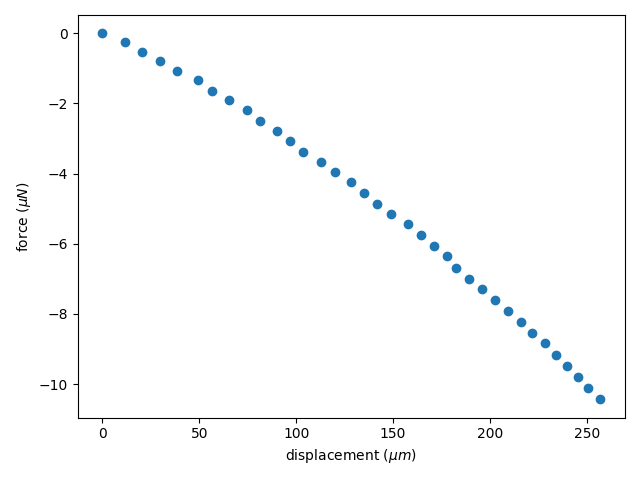

In [98]:
man.analyze_force_displ(root_dir,exp,df=df_out,t0=44,tf=190,plot_loglog=True,reset_force0=True)

## PID

In [14]:
man.analyze_creep(osp.join(root_dir,exp['exp_dir']),
              exp=exp,
              use_retrack=False,
              plot_PID=True,
              vary_beta=False,
              guess={'delta':100,'tau':100,'rate':0.1,'beta':1},
              print_report=False,
              outlier_lim=[None,None],
              moving_avg=10,
              dont_fit=False,  #dont run fitting section
             )

/Users/amichaut/Documents/Work/codes/manipulator/manipylator/analysis.py:887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tip['pos'] = df_tip['pos'] - df_tip.loc[0,'pos']  # center
/Users/amichaut/Documents/Work/codes/manipulator/manipylator/analysis.py:888: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tip['pos'] = sign * df_tip['pos']  # orient
/Users/amichaut/Documents/Work/codes/manipulator/manipylator/analysis.py:895: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

{'creep_fit': {'fit_report': '[[Model]]\n    Model(<lambda>)\n[[Fit Statistics]]\n    # fitting method   = leastsq\n    # function evals   = 75\n    # data points      = 302\n    # variables        = 3\n    chi-square         = 1603.84333\n    reduced chi-square = 5.36402450\n    Akaike info crit   = 510.258789\n    Bayesian info crit = 521.390070\n[[Variables]]\n    delta:  2.3094e-07 +/- 0.51034672 (220984637.96%) (init = 100)\n    tau:    509.653328 +/- 6.6208e+08 (129908725.65%) (init = 100)\n    rate:   0.79838870 +/- 0.00120939 (0.15%) (init = 0.1)\n    beta:   1 (fixed)\n[[Correlations]] (unreported correlations are < 0.100)\n    C(delta, tau) =  0.911\n    C(tau, rate)  =  0.313',
  'delta': 2.3094216894392616e-07,
  'tau': 509.6533282599065,
  'beta': 1,
  'rate': 0.7983886996446516},
 'relax_fit': {'fit_report': '[[Model]]\n    Model(<lambda>)\n[[Fit Statistics]]\n    # fitting method   = leastsq\n    # function evals   = 280\n    # data points      = 295\n    # variables    

### Hough Circle detection, tune parameters

In [64]:
stack_fn = osp.join(root_dir,exp['exp_dir'],exp['fn_image_tip'])
stack = imread(stack_fn)

interactive_plot_param = interactive(man.tune_detect_bead,{'manual': True},
                                     radius=widgets.IntSlider(min=0,max=1000,value=exp['tip_radius']),
                                     radius_err=widgets.FloatSlider(min=0.001,max=0.2,value=0.05,step=1e-3),
                                     blur=widgets.IntSlider(min=1,max=50,value=8),
                                     low_threshold=widgets.IntSlider(min=0,max=255,value=5),
                                     high_threshold=widgets.IntSlider(min=0,max=255,value=10),
                                     frame=widgets.IntSlider(min=0,max=len(stack),value=0),
                                     fn=stack_fn,
                                     stack=True,
                                     continuous_update=False
                                    )
interactive_plot_param

interactive(children=(Text(value='/Users/amichaut/Desktop/20221027_test/04_canti14_oil_sweep/tip.tif', descrip…

In [28]:
# get optimized parameters
radius = interactive_plot_param.children[1].value
#radius_err = interactive_plot_param.children[2].value
radius_err = 1e-3
blur = interactive_plot_param.children[3].value
low_threshold = interactive_plot_param.children[4].value
high_threshold = interactive_plot_param.children[5].value
parallel = True

stack_fn = osp.join(root_dir,exp['exp_dir'],exp['fn_image_tip'])
outdir = osp.join(root_dir,exp['exp_dir'],'bead_tracking')

# run tracking
if parallel:
    arg_dict = {'radius':radius,
                'radius_err':radius_err,
                'blur':blur,
                'low_threshold':low_threshold,
                'high_threshold':high_threshold,
                'outdir':outdir,
                'plot_seg':True,
                'debug':False,
                'save_image':True,
                'dpi':300,
                }
    df_tip = parallel_track_bead(stack_fn,arg_dict)
else: 
    df_tip = track_bead(stack_fn,
                    radius=radius,
                    radius_err=radius_err,
                    blur=blur,
                    low_threshold=low_threshold,
                    high_threshold=high_threshold,
                    outdir=outdir,
                    save_image=True)

df_tip.plot(x='frame',y='cx')


Running parallel detection over 432 frames


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   10.3s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:   12.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.1s
[Parallel(

<AxesSubplot:xlabel='frame'>

## Generate database

In [263]:
refresh = True
assay = 'sweep'
debug = False

fn_out = osp.join(root_dir,'all_data.csv')

if refresh:
    
    # add exclude using a exclude.csv
    df_out = pd.DataFrame()
    dir_list = []
    for d in os.listdir(root_dir):
        if osp.isdir(osp.join(root_dir,d)) and d!='outdata':
            dir_list.append(osp.join(root_dir,d))

    for d in dir_list:
        if assay == "creep":
            df = man.get_creep_outdata(d,debug=debug)
        elif assay == "sweep":
            df = man.get_sweep_outdata(d,debug=debug)
        elif assay == "chirp":
            df = man.get_chirp_outdata(d,debug=debug)
        df_out = pd.concat([df_out,df],ignore_index=True)

    if osp.exists(fn_out):
        os.rename(fn_out,fn_out[:-4]+DT.datetime.now().strftime("%Y%m%d_%H%M%S")+'.csv')
    df_out.to_csv(fn_out)
else:
    df_out = pd.read_csv(fn_out,index_col=0)

# # flow button
# description = "Write flow info" if not osp.exists(info_fn) else "Refresh flow info"
# flow_wid = widgets.Button(value=True, description=description)

# def make_flow_info(obj):
#     exp_flow['tip_radius'] = np.sqrt(exp_flow['contact_area']/np.pi)/lengthscale
#     utils.write_dict(exp_flow,osp.join(exp_flow['exp_dir'],'info.csv'))
    
# flow_wid.on_click(make_flow_info)

In [264]:
df_out

date                             exp  \
0   20230310_spheroids  20230310_spheroids/23_stiff-05   
1   20230310_spheroids   20230310_spheroids/13_soft-03   
2   20230310_spheroids  20230310_spheroids/33_stiff-11   
3   20230310_spheroids   20230310_spheroids/11_soft-02   
4   20230310_spheroids  20230310_spheroids/07_stiff-04   
5   20230310_spheroids  20230310_spheroids/26_stiff-08   
6   20230310_spheroids   20230310_spheroids/17_soft-06   
7   20230310_spheroids  20230310_spheroids/29_stiff-10   
8   20230310_spheroids  20230310_spheroids/03_stiff-02   
9   20230310_spheroids  20230310_spheroids/28_stiff-09   
10  20230310_spheroids   20230310_spheroids/15_soft-04   
11  20230310_spheroids  20230310_spheroids/01_stiff-01   
12  20230310_spheroids   20230310_spheroids/39_soft-10   
13  20230310_spheroids   20230310_spheroids/18_soft-07   
14  20230310_spheroids   20230310_spheroids/37_soft-09   
15  20230310_spheroids   20230310_spheroids/16_soft-05   
16  20230310_spheroids   20230310_spheroids/19_soft-08   
17  20230310_spheroids  20230310_spheroids/24_stiff-06   
18  20230310_spheroids   20230310_spheroids/10_soft-01   
19  20230310_spheroids  20230310_spheroids/25_stiff-07   
20  20230310_spheroids  20230310_spheroids/04_stiff-03   

                                        deflection_fn canti_id canti_length  \
0   20230310_spheroids/23_stiff-05/outdata/deflect...       14        34.14   
1   20230310_spheroids/13_soft-03/outdata/deflecti...       14        34.14   
2   20230310_spheroids/33_stiff-11/outdata/deflect...       14        34.14   
3   20230310_spheroids/11_soft-02/outdata/deflecti...       14        34.14   
4   20230310_spheroids/07_stiff-04/outdata/deflect...       14        34.14   
5   20230310_spheroids/26_stiff-08/outdata/deflect...       14        34.14   
6   20230310_spheroids/17_soft-06/outdata/deflecti...       14        34.14   
7   20230310_spheroids/29_stiff-10/outdata/deflect...       14        34.14   
8   20230310_spheroids/03_stiff-02/outdata/deflect...       14        34.14   
9   20230310_spheroids/28_stiff-09/outdata/deflect...       14        34.14   
10  20230310_spheroids/15_soft-04/outdata/deflecti...       14        34.14   
11  20230310_spheroids/01_stiff-01/outdata/deflect...       14        34.14   
12  20230310_spheroids/39_soft-10/outdata/deflecti...       14        34.14   
13  20230310_spheroids/18_soft-07/outdata/deflecti...       14        34.14   
14  20230310_spheroids/37_soft-09/outdata/deflecti...       14        34.14   
15  20230310_spheroids/16_soft-05/outdata/deflecti...       14        34.14   
16  20230310_spheroids/19_soft-08/outdata/deflecti...       14        34.14   
17  20230310_spheroids/24_stiff-06/outdata/deflect...       14        34.14   
18  20230310_spheroids/10_soft-01/outdata/deflecti...       14        34.14   
19  20230310_spheroids/25_stiff-07/outdata/deflect...       14        34.14   
20  20230310_spheroids/04_stiff-03/outdata/deflect...       14        34.14   

   canti_stiffness contact_area strain_rate  
0         0.018219         None         NaN  
1         0.018219         None         NaN  
2         0.018219         None         NaN  
3         0.018219         None         NaN  
4         0.018219         None         NaN  
5         0.018219         None         NaN  
6         0.018219         None         NaN  
7         0.018219         None         NaN  
8         0.018219         None         NaN  
9         0.018219         None         NaN  
10        0.018219         None         NaN  
11        0.018219         None         NaN  
12        0.018219         None         NaN  
13        0.018219         None         NaN  
14        0.018219         None         NaN  
15        0.018219         None         NaN  
16        0.018219         None         NaN  
17        0.018219         None         NaN  
18        0.018219         None         NaN  
19        0.018219         None         NaN  
20        0.018219         None     

In [265]:
df_out['type'] = ''
df_out['exp_'] = ''
for i in range(df_out.shape[0]):
    exp_param = df.loc[i,'exp'].split("/")
    df_out.loc[i,'exp_'] = exp_param[1]
    df_out.loc[i,'type'] = 'soft' if 'soft' in exp_param[1] else 'stiff'
fn_out = osp.join(root_dir,'all_data.csv')
df_out.to_csv(fn_out)
df_out

date                             exp  \
0   20230310_spheroids  20230310_spheroids/23_stiff-05   
1   20230310_spheroids   20230310_spheroids/13_soft-03   
2   20230310_spheroids  20230310_spheroids/33_stiff-11   
3   20230310_spheroids   20230310_spheroids/11_soft-02   
4   20230310_spheroids  20230310_spheroids/07_stiff-04   
5   20230310_spheroids  20230310_spheroids/26_stiff-08   
6   20230310_spheroids   20230310_spheroids/17_soft-06   
7   20230310_spheroids  20230310_spheroids/29_stiff-10   
8   20230310_spheroids  20230310_spheroids/03_stiff-02   
9   20230310_spheroids  20230310_spheroids/28_stiff-09   
10  20230310_spheroids   20230310_spheroids/15_soft-04   
11  20230310_spheroids  20230310_spheroids/01_stiff-01   
12  20230310_spheroids   20230310_spheroids/39_soft-10   
13  20230310_spheroids   20230310_spheroids/18_soft-07   
14  20230310_spheroids   20230310_spheroids/37_soft-09   
15  20230310_spheroids   20230310_spheroids/16_soft-05   
16  20230310_spheroids   20230310_spheroids/19_soft-08   
17  20230310_spheroids  20230310_spheroids/24_stiff-06   
18  20230310_spheroids   20230310_spheroids/10_soft-01   
19  20230310_spheroids  20230310_spheroids/25_stiff-07   
20  20230310_spheroids  20230310_spheroids/04_stiff-03   

                                        deflection_fn canti_id canti_length  \
0   20230310_spheroids/23_stiff-05/outdata/deflect...       14        34.14   
1   20230310_spheroids/13_soft-03/outdata/deflecti...       14        34.14   
2   20230310_spheroids/33_stiff-11/outdata/deflect...       14        34.14   
3   20230310_spheroids/11_soft-02/outdata/deflecti...       14        34.14   
4   20230310_spheroids/07_stiff-04/outdata/deflect...       14        34.14   
5   20230310_spheroids/26_stiff-08/outdata/deflect...       14        34.14   
6   20230310_spheroids/17_soft-06/outdata/deflecti...       14        34.14   
7   20230310_spheroids/29_stiff-10/outdata/deflect...       14        34.14   
8   20230310_spheroids/03_stiff-02/outdata/deflect...       14        34.14   
9   20230310_spheroids/28_stiff-09/outdata/deflect...       14        34.14   
10  20230310_spheroids/15_soft-04/outdata/deflecti...       14        34.14   
11  20230310_spheroids/01_stiff-01/outdata/deflect...       14        34.14   
12  20230310_spheroids/39_soft-10/outdata/deflecti...       14        34.14   
13  20230310_spheroids/18_soft-07/outdata/deflecti...       14        34.14   
14  20230310_spheroids/37_soft-09/outdata/deflecti...       14        34.14   
15  20230310_spheroids/16_soft-05/outdata/deflecti...       14        34.14   
16  20230310_spheroids/19_soft-08/outdata/deflecti...       14        34.14   
17  20230310_spheroids/24_stiff-06/outdata/deflect...       14        34.14   
18  20230310_spheroids/10_soft-01/outdata/deflecti...       14        34.14   
19  20230310_spheroids/25_stiff-07/outdata/deflect...       14        34.14   
20  20230310_spheroids/04_stiff-03/outdata/deflect...       14        34.14   

   canti_stiffness contact_area strain_rate   type         exp_  
0         0.018219         None         NaN  stiff  23_stiff-05  
1         0.018219         None         NaN   soft   13_soft-03  
2         0.018219         None         NaN  stiff  33_stiff-11  
3         0.018219         None         NaN   soft   11_soft-02  
4         0.018219         None         NaN  stiff  07_stiff-04  
5         0.018219         None         NaN  stiff  26_stiff-08  
6         0.018219         None         NaN   soft   17_soft-06  
7         0.018219         None         NaN  stiff  29_stiff-10  
8         0.018219         None         NaN  stiff  03_stiff-02  
9         0.018219         None         NaN  stiff  28_stiff-09  
10        0.018219         None         NaN   soft   15_soft-04  
11        0.018219         None         NaN  stiff  01_stiff-01  
12        0.018219         None         NaN   soft   39_soft-10  
13        0.018219         None         NaN   soft   18_soft-07  
14        0.

In [161]:
# plot force with respect to temp

outdir = osp.join(root_dir,'outdata')
if not osp.exists(outdir):
    os.mkdir(outdir)

fig, ax = plt.subplots(figsize=(4,3))
for ind in df_out.index:
    fn = osp.join(root_dir,df_out.loc[ind,'deflection_fn'])
    df = pd.read_csv(fn,index_col=0)
    df['t_min'] = df['t'] / 60
    #flip
    if df['deflection'].min() < -10:
        df['deflection'] *= -1
    # chop
    df = df[df['t'] < 7200]
    temp = df_out.loc[ind,'temperature']
    ax.plot(df['t_min'].values,df['deflection'].values,label=r"{}$^\circ$C".format(temp))

ax.set_xlabel('time (min)')
ax.set_ylabel(r'deflection ($\mu m$)')
ax.legend(loc=0)
fig.tight_layout()
plot_fn = osp.join(outdir,'all_data_deflection.png')
fig.savefig(plot_fn,dpi=300)

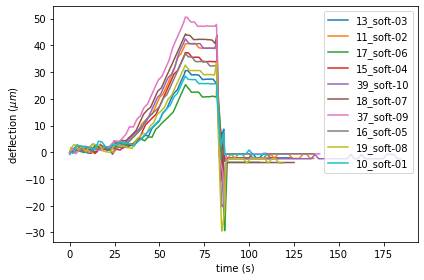

In [268]:
# plot force with respect to temp

outdir = osp.join(root_dir,'outdata')
if not osp.exists(outdir):
    os.mkdir(outdir)
    
t_max_dict = {'soft':300,'stiff':300}

for type_ in ['soft','stiff']: 
    df_sub = df_out[df_out['type'] == type_]
    
    fig, ax = plt.subplots()
    for ind in df_sub.index:
        fn = osp.join(root_dir,df_sub.loc[ind,'deflection_fn'])
        df = pd.read_csv(fn,index_col=0)
        # chop
        df = df[df['t'] < t_max_dict[type_]]
        #flip
        #if df['deflection'].min() < -20:
        #    df['deflection'] *= -1
        lab = df_sub.loc[ind,'exp_']
        ax.plot(df['t'].values,df['deflection'].values,label=lab)

    ax.set_xlabel('time (s)')
    ax.set_ylabel(r'deflection ($\mu m$)')
    ax.legend(loc=0)
    fig.tight_layout()
    plot_fn = osp.join(outdir,'all_data_deflection_{}.png'.format(type_))
    fig.savefig(plot_fn,dpi=300)

In [269]:
color_list = [c['color'] for c in list(plt.rcParams['axes.prop_cycle'])]

fig, ax = plt.subplots()
for ind in df_out.index:
    type_ = df_out.loc[ind,'type']
    fn = osp.join(root_dir,df_out.loc[ind,'deflection_fn'])
    df = pd.read_csv(fn,index_col=0)
    # chop
    df = df[df['t'] < 30]
    #flip
    if df['deflection'].min() < -10:
        df['deflection'] *= -1
    color = color_list[0] if type_ == 'soft' else color_list[1]
    ax.plot(df['t'].values,df['deflection'].values,color=color)

ax.plot([],[],color=color_list[0],label="soft")
ax.plot([],[],color=color_list[1],label="stiff")
    
ax.set_xlabel('time (s)')
ax.set_ylabel(r'deflection ($\mu m$)')
ax.legend(loc=0)
fig.tight_layout()
plot_fn = osp.join(outdir,'all_data_deflection_short_time.png')
fig.savefig(plot_fn,dpi=300)

In [160]:
# categorize type
df_out = pd.read_csv(fn_out,index_col=0)
df_out['type'] = ''
df_out
for i in df_out.index:
    if 'soft' in df_out.loc[i,'exp']: 
        df_out.loc[i,'type'] = 'soft'
    else: 
        df_out.loc[i,'type'] = 'stiff'
df_out.to_csv(fn_out)

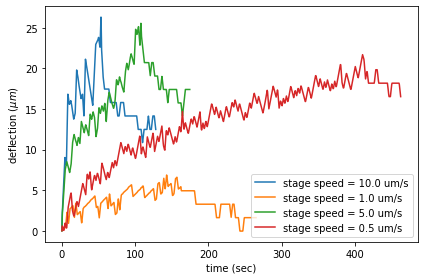

In [162]:
# plot force with respect to type

outdir = osp.join(root_dir,'outdata')
if not osp.exists(outdir):
    os.mkdir(outdir)

fig, ax = plt.subplots()
for ind in df_out.index:
    fn = osp.join("/Users/amichaut/Desktop/",df_out.loc[ind,'deflection_fn'])
    df = pd.read_csv(fn,index_col=0)
    #flip
    if df['deflection'].min() < -10:
        df['deflection'] *= -1
    speed = df_out.loc[ind,'stage_speed']
    ax.plot(df['t'].values,df['deflection'].values,label="stage speed = {} um/s".format(speed))

ax.set_xlabel('time (sec)')
ax.set_ylabel(r'deflection ($\mu m$)')
ax.legend(loc=0)
fig.tight_layout()
plot_fn = osp.join(outdir,'all_data_deflection.png')
fig.savefig(plot_fn,dpi=300)

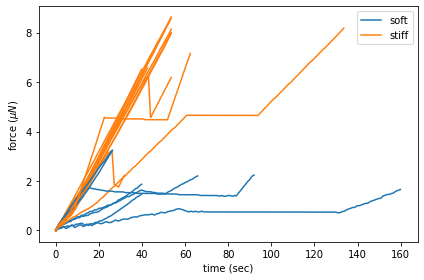

In [150]:
# plot force with respect to type

outdir = osp.join(root_dir,'outdata')
if not osp.exists(outdir):
    os.mkdir(outdir)

for type_ in df_out['type'].unique():
    sub_df = df_out[df_out['type']==type_]
    fig, ax = plt.subplots()
    i=0
    for ind in sub_df.index:
        fn = osp.join(root_dir,sub_df.loc[ind,'deflection_fn'])
        df = pd.read_csv(fn,index_col=0)
        ax.plot(df['t'].values,df['force'].values,color=color_list[i],label=sub_df.loc[ind,'exp'])  #label=sub_df.loc[ind,'exp']
        i+=1
        
    ax.set_xlabel('time (sec)')
    ax.set_ylabel(r'force ($\mu N$)')
    ax.legend(loc=0)
    fig.tight_layout()
    plot_fn = osp.join(outdir,type_+'.png')
    fig.savefig(plot_fn,dpi=300)
    
fig, ax = plt.subplots()
color_count = {'soft':0,'stiff':0}
for ind in df_out.index:
    fn = osp.join(root_dir,df_out.loc[ind,'deflection_fn'])
    df = pd.read_csv(fn,index_col=0)
    type_ = df_out.loc[ind,'type']
    color_i = 0 if type_ == 'soft' else 1
    lab = type_ if color_count[type_] == 0 else None
    color_count[type_] += 1
    ax.plot(df['t'].values,df['force'].values,color=color_list[color_i],label=lab)

ax.set_xlabel('time (sec)')
ax.set_ylabel(r'force ($\mu N$)')
ax.legend(loc=0)
fig.tight_layout()
plot_fn = osp.join(outdir,'all_data.png')
fig.savefig(plot_fn,dpi=300)

In [5]:
plot_pooled_Gstar(df_out,root_dir,label='exp',color_code=None)

exp
exp
exp
exp


In [82]:
batch_analyze_chirp(df_out,root_dir)

In [92]:
outdir = osp.join(root_dir,'outdata')

stress_list = []
canti_stiffness = []
contact_area = []
colors = []

i = 0
for ind in df_out.index:
    fn = osp.join(root_dir,df_out.loc[ind,'deflection_fn'])
    df = pd.read_csv(fn,index_col=0)
    stress_list.append((df['stress'].max()-df['stress'].min())/2)
    canti_stiffness.append(df_out.loc[ind,'canti_stiffness'])
    contact_area.append(df_out.loc[ind,'contact_area'])
    colors.append(color_list[i%len(color_list)])
    i += 1

fig, ax = plt.subplots()
ax.scatter(contact_area,stress_list,color=colors)
ax.set_ylabel(r"stress amplitude (N/m)")
ax.set_xlabel(r'contact_area $(\mu m^2)$')
fig.tight_layout()
fig.savefig(osp.join(outdir,'stress_vs_area.png'),dpi=300)
                        
fig, ax = plt.subplots()
ax.scatter(canti_stiffness,stress_list,color=colors)
ax.set_ylabel(r"stress amplitude (N/m)")
ax.set_xlabel('cantilever stiffness (N/m)')
fig.tight_layout()
fig.savefig(osp.join(outdir,'stress_vs_cantistiffness.png'),dpi=300)

plt.close('all')
    

/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


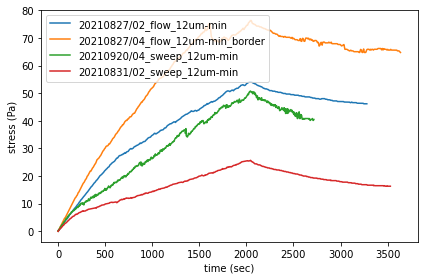

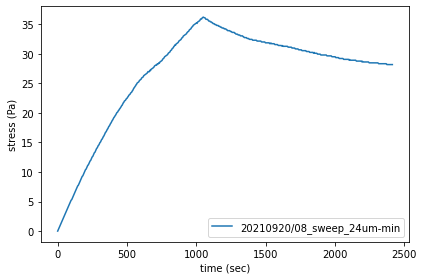

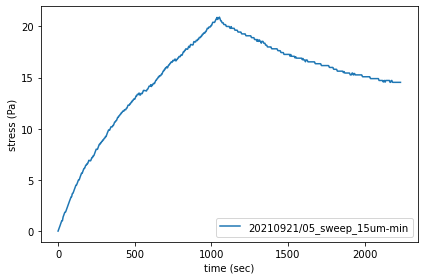

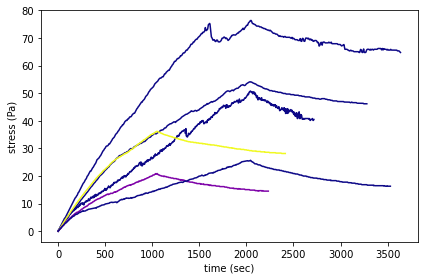

In [60]:
## PLOT POOLED FLOW EXP

outdir = osp.join(root_dir,'outdata')
if not osp.exists(outdir):
    os.mkdir(outdir)
    
cmap = plt.get_cmap('plasma')

for rate in df_out['strain_rate'].unique():
    sub_df = df_out[df_out['strain_rate']==rate]
    fig, ax = plt.subplots()
    i=0
    for ind in sub_df.index:
        fn = osp.join(root_dir,sub_df.loc[ind,'deflection_fn'])
        df = pd.read_csv(fn,index_col=0)
        ax.plot(df['t'].values,df['stress'].values,color=color_list[i],label=sub_df.loc[ind,'exp'])
        i+=1
        
    ax.set_xlabel('time (sec)')
    ax.set_ylabel(r'stress (Pa)')
    ax.legend(loc=0)
    fig.tight_layout()
    plot_fn = osp.join(outdir,'all_deflection_rate_{:.2f}.png'.format(rate))
    fig.savefig(plot_fn,dpi=300)

#plot together
norm = plt.Normalize(df_out['strain_rate'].min(), df_out['strain_rate'].max())
fig, ax = plt.subplots()
for ind in df_out.index:
    fn = osp.join(root_dir,df_out.loc[ind,'deflection_fn'])
    df = pd.read_csv(fn,index_col=0)
    
    color = cmap(norm(df_out.loc[ind,'strain_rate']))
    ax.plot(df['t'].values,df['stress'].values,color=color)
        
ax.set_xlabel('time (sec)')
ax.set_ylabel(r'stress (Pa)')
fig.tight_layout()
plot_fn = osp.join(outdir,'all_deflection.png')
fig.savefig(plot_fn,dpi=300)

plot_cmap(outdir, "strain rate (um/min)", cmap, df_out['strain_rate'].min(), df_out['strain_rate'].max())

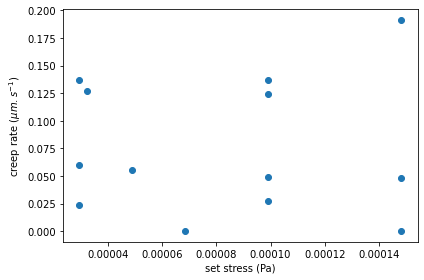

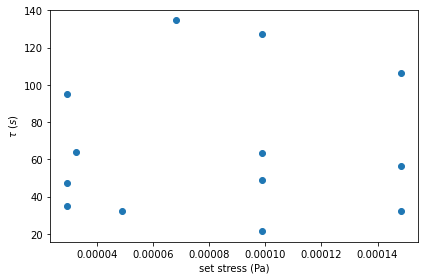

In [24]:
## PLOT CREEP FIT PARAMETERS

outdir = osp.join(root_dir,'outdata')
if not osp.exists(outdir):
    os.mkdir(outdir)
    
fig,ax = plt.subplots()
ax.scatter(df_out['set_stress'].values,df_out['rate'].values)
ax.set_xlabel(r'set stress (Pa)')
ax.set_ylabel(r'creep rate ($\mu m.s^{-1}$)')
fig.tight_layout()
plot_fn = osp.join(outdir,'all_rate.png')
fig.savefig(plot_fn,dpi=300)

fig,ax = plt.subplots()
ax.scatter(df_out['set_stress'].values,df_out['delta'].values)
ax.set_xlabel(r'set stress (Pa)')
ax.set_ylabel(r'$\delta$ ($\mu m$)')
fig.tight_layout()
plot_fn = osp.join(outdir,'all_delta.png')
fig.savefig(plot_fn,dpi=300)

fig,ax = plt.subplots()
ax.scatter(df_out['set_stress'].values,df_out['tau'].values)
ax.set_xlabel(r'set stress (Pa)')
ax.set_ylabel(r'$\tau$ ($s$)')
fig.tight_layout()
plot_fn = osp.join(outdir,'all_tau.png')
fig.savefig(plot_fn,dpi=300)

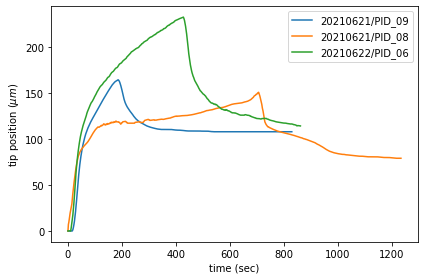

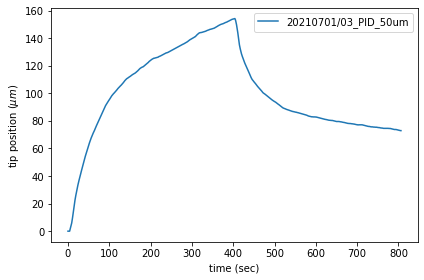

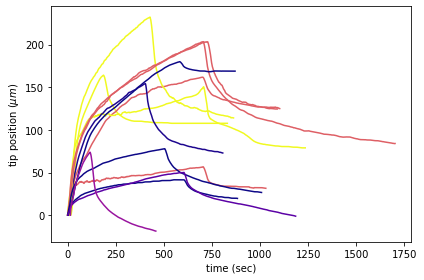

In [63]:
## PLOT POOLED CREEP CURVED

outdir = osp.join(root_dir,'outdata')
if not osp.exists(outdir):
    os.mkdir(outdir)
    
cmap = plt.get_cmap('plasma')


for stress in df_out['set_stress'].unique():
    sub_df = df_out[df_out['set_stress']==stress]
    fig, ax = plt.subplots()
    i=0
    for ind in sub_df.index:
        fn = osp.join(root_dir,sub_df.loc[ind,'creep_fn'])
        df = pd.read_csv(fn,index_col=0)
        ax.plot(df['t'].values,df['pos'].values,color=color_list[i],label=sub_df.loc[ind,'exp'])
        i+=1
        
    ax.set_xlabel('time (sec)')
    ax.set_ylabel(r'tip position ($\mu m$)')
    ax.legend(loc=0)
    fig.tight_layout()
    plot_fn = osp.join(outdir,'all_creep_stress_{}.png'.format(stress))
    fig.savefig(plot_fn,dpi=300)
    
#plot together
norm = plt.Normalize(df_out['set_stress'].min(), df_out['set_stress'].max())
fig, ax = plt.subplots()
for ind in df_out.index:
    fn = osp.join(root_dir,df_out.loc[ind,'creep_fn'])
    df = pd.read_csv(fn,index_col=0)
    
    color = cmap(norm(df_out.loc[ind,'set_stress']))
    ax.plot(df['t'].values,df['pos'].values,color=color)
        
ax.set_xlabel('time (sec)')
ax.set_ylabel(r'tip position ($\mu m$)')
fig.tight_layout()
plot_fn = osp.join(outdir,'all_creep.png')
fig.savefig(plot_fn,dpi=300)

plot_cmap(outdir, "set stress (Pa)", cmap, df_out['set_stress'].min(), df_out['set_stress'].max())

Exception: ERROR: File does not exist. Aborting...

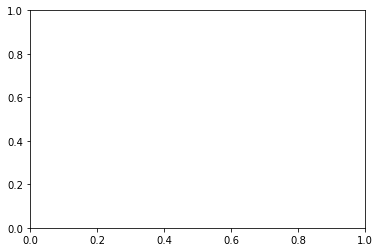

In [3]:
root_dir = "/Users/amichaut/Desktop"
suffix = ''

dir_list = []
for d in os.listdir(root_dir):
    if osp.isdir(osp.join(root_dir,d)) and d!='outdata':
        dir_list.append(d)

dir_list = ["01_PID_75um","02_PID_125um","03_PID_175um"]
# dir_list = []
# root_dirs=['20210621','20210622','20210701','20210727']
# for r in root_dirs:
#     r_ = osp.join(root_dir,r)
#     for d in os.listdir(r_):
#         if osp.isdir(osp.join(r_,d)):
#             if "PID" in d:
#                 dir_list.append(osp.join(r_,d))


# plot raw curves
fig,ax = plt.subplots()

for d in dir_list: 
    exp = load_dict(osp.join(root_dir,d,'info.csv'))
    data_fn = osp.join(exp['exp_dir'],'outdata','creep.csv')
    fit_fn = osp.join(exp['exp_dir'],'outdata','creep_fit.csv')
    df = pd.read_csv(data_fn)
    df_fit = pd.read_csv(fit_fn)
    df.plot(x='t',y='pos',ax=ax,label=str(exp['set_deflection'])+' um'+' - '+osp.split(exp['exp_dir'])[1])
    #df_fit.plot(x='t',y='pos',ax=ax,legend=False)

ax.set_xlabel('time (sec)')
ax.set_ylabel(r'tip position ($\mu m$)')
ax.legend(loc=4)
fig.tight_layout()
plot_fn = osp.join(root_dir,'all_creep'+suffix+'.png')
fig.savefig(plot_fn,dpi=300)

# plot rate against setpoint
fig,ax = plt.subplots()
setpoint_list = []
rate_list = []

for d in dir_list: 
    exp = load_dict(osp.join(root_dir,d,'info.csv'))
    fn = osp.join(exp['exp_dir'],'outdata','creep_fitparam.csv')
    fit_dict = load_dict(fn)
    setpoint_list.append(exp['set_deflection'])
    rate_list.append(fit_dict['rate'])
    
plt.scatter(setpoint_list,rate_list)
ax.set_xlabel(r'set deflection ($\mu m$)')
ax.set_ylabel(r'creep rate ($\mu m.s^{-1}$)')
fig.tight_layout()
plot_fn = osp.join(root_dir,'all_rate'+suffix+'.png')
fig.savefig(plot_fn,dpi=300)

# calculate stiffness

In [5]:
length = 29  # in mm
print('stiffness = {} uN/um'.format(man.compute_canti_stiffness(length)))

stiffness = 0.029725 uN/um


## synthetic data

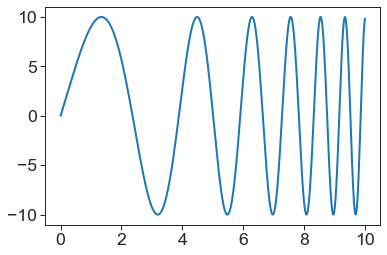

In [36]:
x0=10
w1=1
w2=10
T=10
N=1000
t=np.linspace(0,T,1000)
x=x0*np.sin((w1*T/np.log(w2/w1))*(np.exp(np.log(w2/w1)*t/T)-1))
plot(t,x)

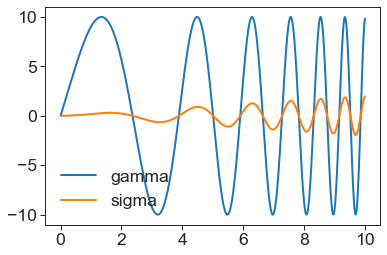

In [37]:
#G*=FFT(sigma)/FFT(gamma)
#try to look at a profile of sigma which amplitude increases with t (stiffer at higher frequency)

gamma=x
sigma=x*t/50

fig,ax=plt.subplots()
ax.plot(t,gamma,color=color_list[0],label='gamma')
ax.plot(t,sigma,color=color_list[1],label='sigma')
ax.legend(frameon=False)

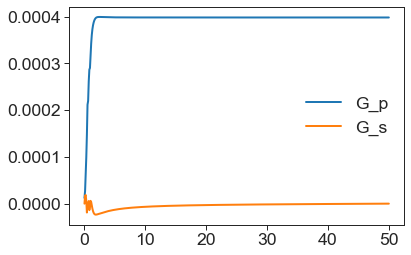

In [39]:
gamma_=np.fft.fft(gamma)
sigma_=np.fft.fft(sigma)
G_star=sigma_/gamma_
G_p=np.real(G_star)
G_s=np.imag(G_star)

xf = np.linspace(0.0, 1.0*N/(2.0*T), N//2)

fig,ax=plt.subplots()
#ax.plot(G_p,color=color_list[0],label='G_p')
#ax.plot(G_s,color=color_list[1],label='G_s')
ax.plot(xf,2.0/N * G_p[0:N//2],color=color_list[0],label='G_p')
ax.plot(xf,2.0/N * G_s[0:N//2],color=color_list[1],label='G_s')
ax.legend(frameon=False)

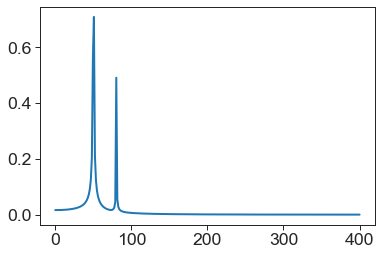

In [40]:
#FFT tutorial

N = 600
#T = 1.0 / 800.0
T_ = 0.75
x = np.linspace(0.0, T_, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = np.fft.fft(y)
xf = np.linspace(0.0, 1.0*N/(2.0*T_), N//2)
plot(xf, 2.0/N * np.abs(yf[0:N//2]))

<IPython.core.display.Javascript object>


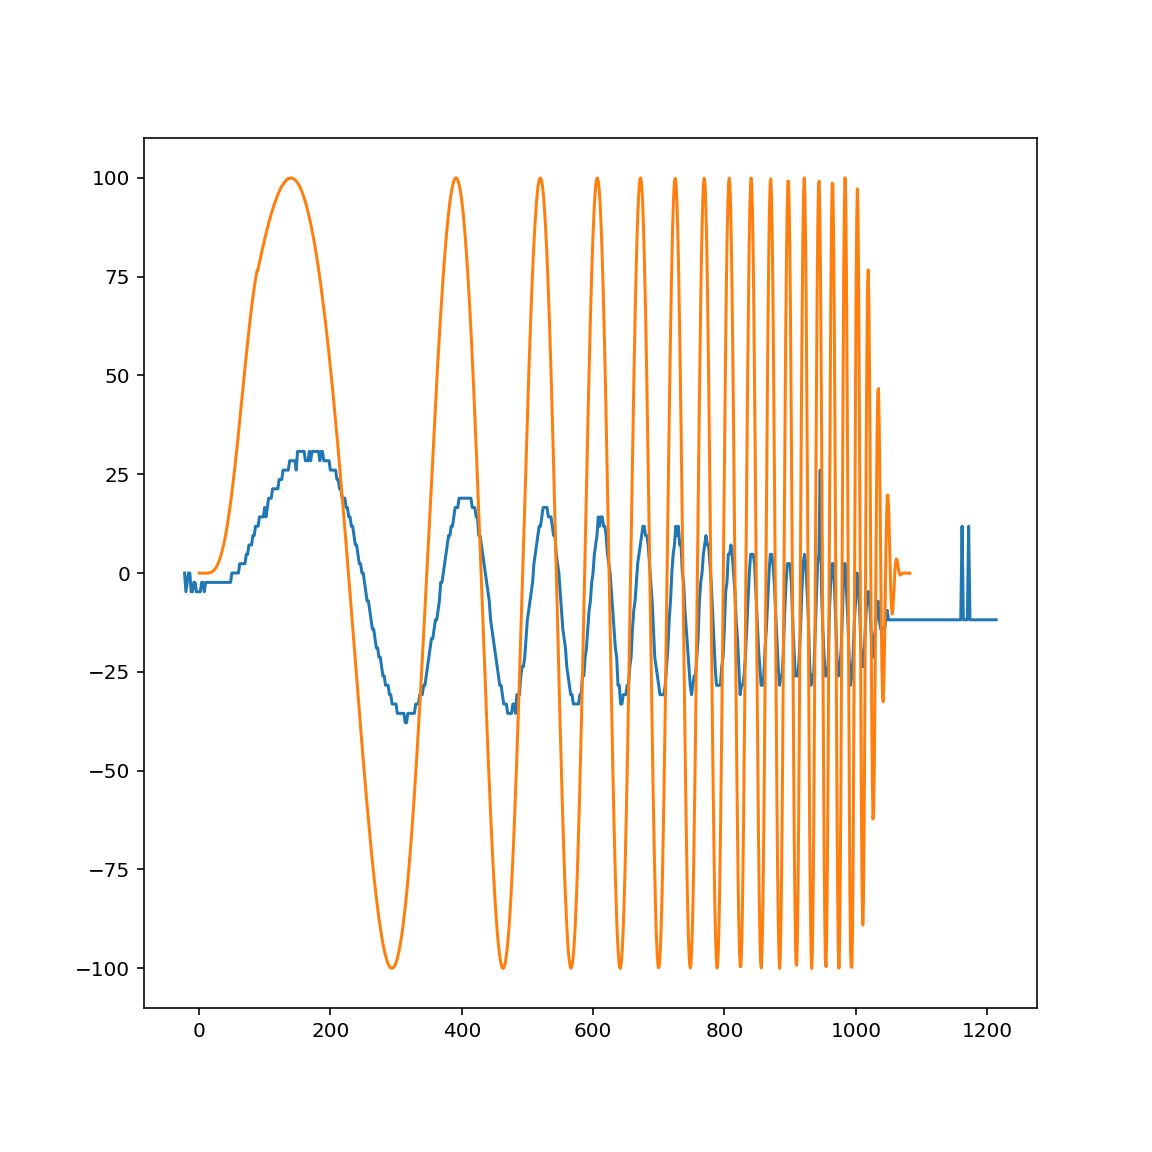

In [13]:
%matplotlib notebook
df_tip = pd.read_csv(osp.join(fc.selected_path,'outdata','tip.csv'),index_col = 0)
df_stage = pd.read_csv(osp.join(fc.selected_path,'outdata','stage.csv'),index_col = 0)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(df_tip['t_ref'].values,df_tip['centered_pos'].values, color=color_list[0],label='tip')
ax.plot(df_stage['t_ref'].values,df_stage['centered_pos'].values, color=color_list[1],label='stage')

In [5]:
def detect_div(fn,radius=10,radius_err=0.05,blur=3,low_threshold=10,high_threshold=15,frame=0,stack=True,max_num_peaks=50): 
    # Load picture and detect edges
    if stack:
        stack = imread(fn)
        image = stack[frame]
    else: 
        image = imread(fn)

    image = img_as_ubyte(image) #convert to 8bit
    edges = canny(image, sigma=blur, low_threshold=low_threshold, high_threshold=high_threshold)

    # Detect array of radii
    hough_radii = np.arange(int(radius-radius_err*radius), int(radius+radius_err*radius)+1)
    hough_res = hough_circle(image, hough_radii)

    # Select the most prominent circle
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,total_num_peaks=max_num_peaks)
    if len(cy)==0:
        raise Exception("No circle detected. Aborting...")

    fig,axes = plt.subplots(1,2,figsize=(12,24))
    
    # convert images to rgb
    image = gray2rgb(image)
    edges = img_as_ubyte(edges)  # binary to grayscale
    edges = gray2rgb(edges)  # grayscale to rgb 
    
    for k in range(len(radii)):
        center_y = cy[k]
        center_x = cx[k]
        radius = radii[k]
        # draw detection on image as a circle in and a cross
        for i in np.arange(-1,2): #draw 3 px thick lines
            #draw circle
            circy, circx = circle_perimeter(center_y, center_x, radius+i,
                                            shape=image.shape)
            image[circy, circx] = hex_to_rgb(color_list[0])
            edges[circy, circx] = hex_to_rgb(color_list[0])

            #draw center cross
            rr, cc = line(center_y+i, center_x-5, center_y+i, center_x+5)
            rr_, cc_ = line(center_y-5, center_x+i, center_y+5, center_x+i)
            image[rr, cc] = hex_to_rgb(color_list[1])
            image[rr_, cc_] = hex_to_rgb(color_list[1])

    axes[0].imshow(edges, aspect='equal')
    axes[1].imshow(image, aspect='equal')
    plt.show(fig)

    return [center_x, center_y, radius]

In [7]:
stack_fn = "/Users/amichaut/Desktop/mb.tif"
stack = imread(stack_fn)
cell_radius = 10

interactive_div = interactive(tune_detect_bead,{'manual': True},
                                     radius=widgets.IntSlider(min=0,max=100,value=cell_radius),
                                     radius_err=widgets.FloatSlider(min=0.001,max=0.2,value=0.05,step=1e-3),
                                     blur=widgets.IntSlider(min=1,max=50,value=8),
                                     low_threshold=widgets.IntSlider(min=0,max=255,value=5),
                                     high_threshold=widgets.IntSlider(min=0,max=255,value=10),
                                     frame=widgets.IntSlider(min=0,max=len(stack),value=0),
                                     max_num_peaks=widgets.IntSlider(min=0,max=1000,value=1000),
                                     fn=stack_fn,
                                     stack=True,
                                     continuous_update=False
                                    )
interactive_div

interactive(children=(Text(value='/Users/amichaut/Desktop/mb.tif', description='fn'), IntSlider(value=10, desc…

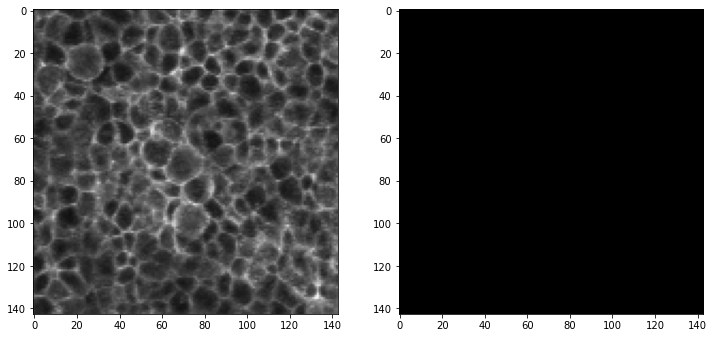

In [46]:
from skimage import filters
from skimage import util

image = imread("/Users/amichaut/Desktop/mb_sub_avg.tif")
#image = stack[0]

image = img_as_ubyte(image) #convert to 8bit
#image = image[300:400, 300:400]


image = filters.gaussian(image,sigma=0)
edges = filters.sobel(image)
#edges = util.invert(edges)
edges = canny(edges, sigma=1, low_threshold=1, high_threshold=1)

image = gray2rgb(image)
edges = img_as_ubyte(edges)  # binary to grayscale
edges = gray2rgb(edges)  # grayscale to rgb 

fig,axes = plt.subplots(1,2,figsize=(12,24))
axes[0].imshow(image, aspect='equal')
axes[1].imshow(edges, aspect='equal')
plt.show(fig)

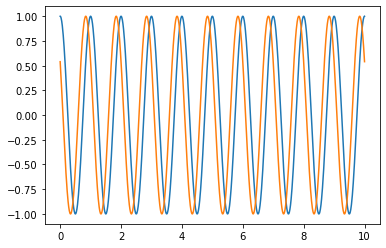

In [21]:
num_points = 1000
T = 10
t = np.linspace(0,T,num_points)
x1 = np.cos(2*np.pi*t)
x2 = np.cos(2*np.pi*t+1)

plt.plot(t,x1,color=color_list[0])
plt.plot(t,x2,color=color_list[1])

x1_ = np.fft.fft(x1)
x2_ = np.fft.fft(x2)
f = np.fft.fftfreq(num_points, d=T/num_points) #frequencies
omega = f*2*np.pi #angular frequencies

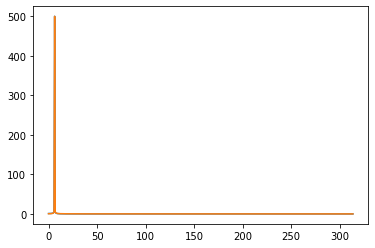

In [22]:
plt.plot(omega[0:num_points//2],np.abs(x1_)[0:num_points//2],color=color_list[0])
plt.plot(omega[0:num_points//2],np.abs(x2_)[0:num_points//2],color=color_list[1])

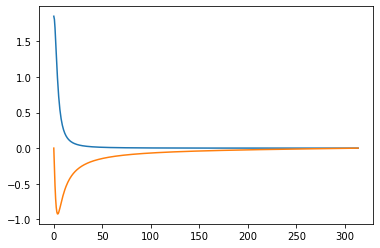

In [23]:
G_star = x1_/x2_
G_p = np.real(G_star)
G_s = np.imag(G_star)
plt.plot(omega[0:num_points//2],G_p[0:num_points//2],color=color_list[0])
plt.plot(omega[0:num_points//2],G_s[0:num_points//2],color=color_list[1])

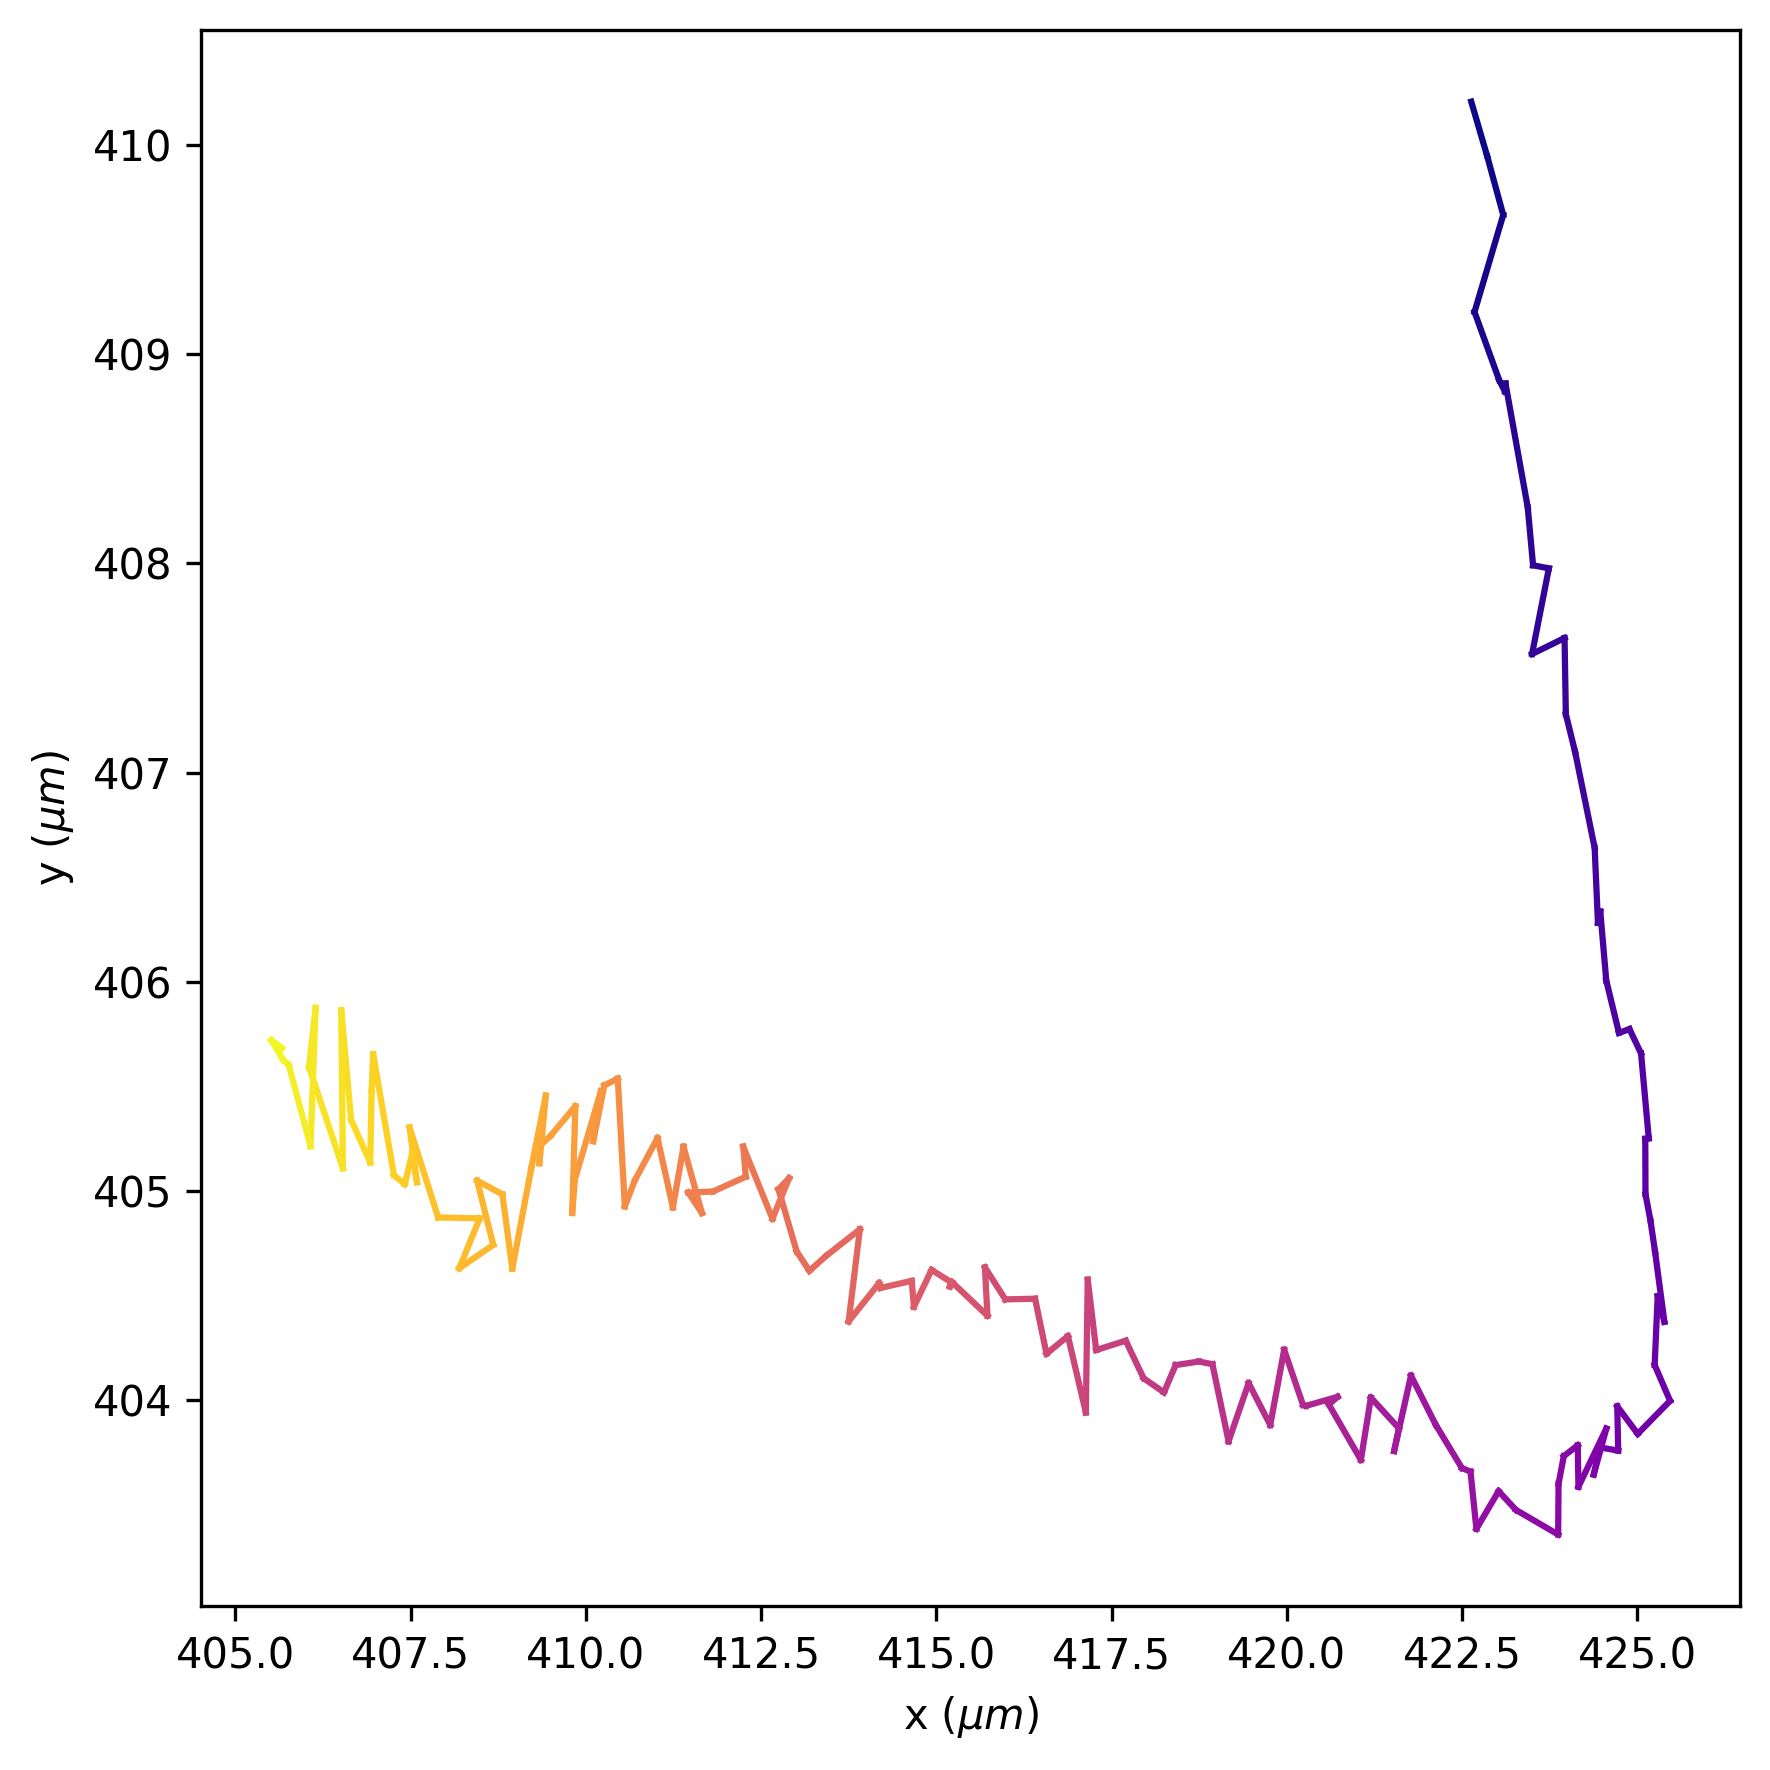

In [10]:
man.plot_colored_traj(fc_czi.selected,lengthscale=1)